In [3]:
import pandas as pd
import numpy as np
import copy
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
import sklearn
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('amazon.csv')
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
# число значений у признаков
max_value = 0
for col_name in data.columns:
    max_value = max(max_value, np.max(data[col_name]))
print(max_value)

312153


In [5]:
def get_pair_features(X):
    print("Begin")
    X_new = np.ndarray((X.shape[0], X.shape[1] * (X.shape[1] + 1) // 2))
    X_new[:, 0:X.shape[1]] = copy.deepcopy(X.iloc[:])
    print("End copy")
    len = X.shape[1]
    for i in range(X.shape[1]):
        print("Processing", i, "features")
        for j in range(i + 1, X.shape[1]):
            for k in range(X.shape[0]):
                X_new[k, len] = str(X.iloc[k, i]) + "0123321" + str(X.iloc[k, j])
            len += 1
    return X_new

In [6]:
X_train_with_pair_features = get_pair_features(X_train)
X_test_with_pair_features = get_pair_features(X_test)

Begin
End copy
Processing 0 features
Processing 1 features
Processing 2 features
Processing 3 features
Processing 4 features
Processing 5 features
Processing 6 features
Processing 7 features
Processing 8 features
Begin
End copy
Processing 0 features
Processing 1 features
Processing 2 features
Processing 3 features
Processing 4 features
Processing 5 features
Processing 6 features
Processing 7 features
Processing 8 features


In [7]:
def get_new_features(X, count, successed):
    cnt = 0
    new_X = np.ndarray((X.shape[0], 3 * X.shape[1]))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            new_X[i, 3 * j] = count[j].get(X[i, j], 0)
            new_X[i, 3 * j + 1] = successed[j].get(X[i, j], 0)
            new_X[i, 3 * j + 2] = (new_X[i, 3 * j + 1] + 1) / (new_X[i, 3 * j] + 2)
            cnt += new_X[i, 3 * j] == 0;
    print(cnt)
    return new_X

def get_count_and_successed(X_train, y_train):
    count = [{} for i in range(X_train.shape[1])]
    successed = [{} for i in range(X_train.shape[1])]
    for col in range(X_train.shape[1]):
        value, len = unique_with_count(X_train[:, col])
        
        count[col] = {cur_value: 0 for cur_value in value}
        successed[col] = {cur_value: 0 for cur_value in value}
        for ind in range(X_train.shape[0]):
            count[col][X_train[ind, col]] += 1
            successed[col][X_train[ind, col]] += (y_train[ind] == 1)
        for cur_value in value:
            count[col][cur_value] /= y_train.shape[0]
            successed[col][cur_value] /= y_train.shape[0]
            
    return (count, successed)

In [13]:
def unique_with_count(input_array): # (value, count)
    buf = copy.deepcopy(input_array)
    buf = buf[buf == buf]
    buf = np.sort(buf)
    
    Y = np.concatenate((buf[1:], np.array([np.nan])))
    lens_seg = np.cumsum(np.ones(buf.shape[0]))
    val = buf[buf != Y]
    lens_seg = lens_seg[buf != Y]
    lens_seg = np.asarray(np.concatenate((lens_seg[0:1], np.diff(lens_seg))), dtype = int)
    return (val, lens_seg)


p_2 = np.zeros((X_train.shape[1], max_value + 1))
p = np.zeros((X_train.shape[1], max_value + 1))
f = np.zeros((X_train.shape[1], max_value + 1))
for col in range(X_train.shape[1]):
    (unique_value, count) = unique_with_count(X_train.iloc[:, col])
    cur_f = count
    cur_p = (count + 0.0) / X_train.shape[0]
    cur_p_2 = count * (count - 1.0) / X_train.shape[0] / (X_train.shape[0] - 1)
    sum_p_2 = np.zeros(unique_value.shape[0])
    for i in range(unique_value.shape[0]):
        sum_p_2[i] = np.sum(cur_p_2[cur_p < cur_p[i]])
    
    f[col][unique_value] = cur_f
    p[col][unique_value] = cur_p
    p_2[col][unique_value] = sum_p_2
    
log_f = np.log(f + 1)


In [18]:
def display_auc(y_true, y_predict):
    print("AUC:", sklearn.metrics.roc_auc_score(y_score=y_predict, y_true=y_true))
    (fpr, tpr, thresholds) = sklearn.metrics.roc_curve(y_true=y_true, y_score=y_predict)
    plt.plot(fpr, tpr)
    plt.show()

def get_auc(y_true, y_predict):
    return sklearn.metrics.roc_auc_score(y_score=y_predict, y_true=y_true)

In [27]:
count, successed = get_count_and_successed(X_train_with_pair_features, np.array(y_train.iloc[:], dtype=int))
new_X_train_with_pair_features = get_new_features(X_train_with_pair_features, count, successed)
new_X_test_with_pair_features = get_new_features(X_test_with_pair_features, count, successed)

0
44734


In [28]:
def find_optimal_k(X_train, y_train, X_test, y_test, MAXK, metric, metric_params = None):
    MAXK += 1
    classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=MAXK, 
                                                        algorithm='brute', 
                                                        metric=metric,
                                                        metric_params=metric_params)
    classifier.fit(X_train, y_train)
    nearest_class = classifier.kneighbors(X_test, return_distance=0)
    precision = np.ndarray((MAXK, X_test.shape[0], 2))
    for ind_object in range(X_test.shape[0]):
        histohram = np.zeros(2)
        for k in range(0, MAXK):
            histohram[y_train.iloc[nearest_class[ind_object][k]]] += 1
            precision[k, ind_object] = histohram / (k + 1)
    
    max_auc = 0.0
    max_k = 0;
    max_y = None
    for k in range(0, MAXK):
        y_predict = precision[k, :, 1]
        cur_auc = get_auc(y_true = y_test, y_predict = y_predict)
        if (cur_auc > max_auc):
            max_auc = cur_auc
            max_k = k + 1
            max_y = y_predict
            
    display_auc(y_true=y_test, y_predict=max_y)
    return (max_auc, max_k)

AUC: 0.80338239808


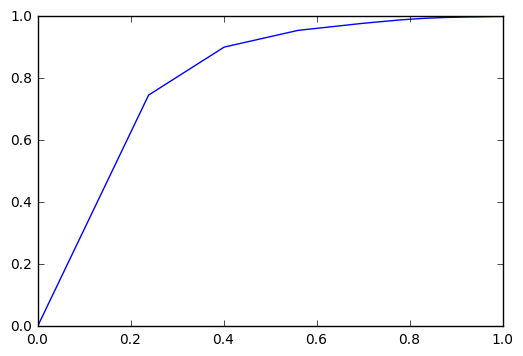

(0.80338239808039713, 10)


In [29]:
#WITHOUT FOLDING
print(find_optimal_k(new_X_train_with_pair_features, y_train, new_X_test_with_pair_features, y_test, 30, 'euclidean'))

#neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=14, 
#                                               algorithm='brute', 
#                                               metric='euclidean')

#neigh.fit(new_X_train_with_pair_features, y_train)


#y = neigh.predict_proba(new_X_test_with_pair_features)
#y = y[:, 1]

#display_auc(y_true = y_test, y_predict = y)

42718
42865
43297
44734
AUC: 0.786943587222


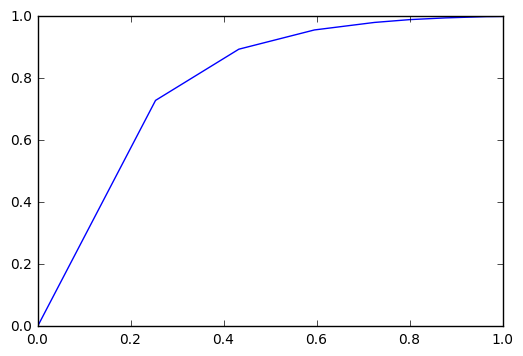

(0.78694358722210367, 10)


In [26]:
#WITH FOLDING
def get_new_features_with_fold(X, y, CNT_FOLDS = 3):
    new_X = np.ndarray((X.shape[0], 3 * X.shape[1]))
    for i in range(CNT_FOLDS):
        ind = np.ndarray(((X.shape[0] + CNT_FOLDS - 1 - i) // CNT_FOLDS), dtype=int)
        other_ind = np.ndarray(X.shape[0] - ind.shape[0], dtype=int)
        cnt = 0
        cnt_other = 0
        for j in range(X.shape[0]):
            if (j % CNT_FOLDS == i):
                ind[cnt] = j
                cnt += 1
            else:
                other_ind[cnt_other] = j
                cnt_other += 1

        count, successed = get_count_and_successed(X[other_ind, :], y[other_ind])
        X_chunk_new = get_new_features(X[ind, :], count, successed)
        new_X[ind, :] = X_chunk_new
    return new_X

CNT_FOLDS = 3
new_X_train_with_pair_features = get_new_features_with_fold(X_train_with_pair_features, np.array(y_train, dtype=int), CNT_FOLDS)


count, successed = get_count_and_successed(X_train_with_pair_features, np.array(y_train, dtype=int))
new_X_test_with_pair_features = get_new_features(X_test_with_pair_features, count, successed)


print(find_optimal_k(new_X_train_with_pair_features, y_train, new_X_test_with_pair_features, y_test, 30, 'euclidean'))


#neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=16, 
#                                               algorithm='brute', 
#                                               metric='euclidean')

#neigh.fit(new_X_train_with_pair_features, np.array(y_train, dtype=int))


#y = neigh.predict_proba(new_X_test_with_pair_features)
#y = y[:, 1]

#display_auc(y_true = y_test, y_predict = y)